## Edit

* edited the sky-subtraction from 1-2; 2-1; 3-2; 4-3; 5-4 to 1-2; 2-1; 3-5; 4-3; 5-3.
* added hot pix and bkg_subtraction
* see *_alignment.ipynb using im_reg

see also [Benisty+2015](https://www.aanda.org/articles/aa/pdf/2015/06/aa26011-15.pdf)

In [15]:
from datetime import datetime as dt

dt.now()

datetime.datetime(2017, 11, 2, 13, 27, 14, 892913)

In [16]:
!python --version

Python 3.5.3 :: Continuum Analytics, Inc.


In [17]:
import os
os.environ['CONDA_DEFAULT_ENV']

'iraf35'

## skysubtraction (next dither)

In [18]:
import glob
import getpass
import os
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

ndither=5
wpangle=4
nframes=3

skysub_ch1 = glob.glob('*fgs_ch1.fits')
skysub_ch1.sort()
skysub_ch2 = glob.glob('*fgs_ch2.fits')
skysub_ch2.sort()

## Check sky-subtracted frames

Sky subtraction was done as follows:
* dither 1 - dither 2
* dither 2 - dither 1
* dither 3 - dither 2
* dither 4 - dither 3
* dither 5 - dither 4

## all 5 dithers

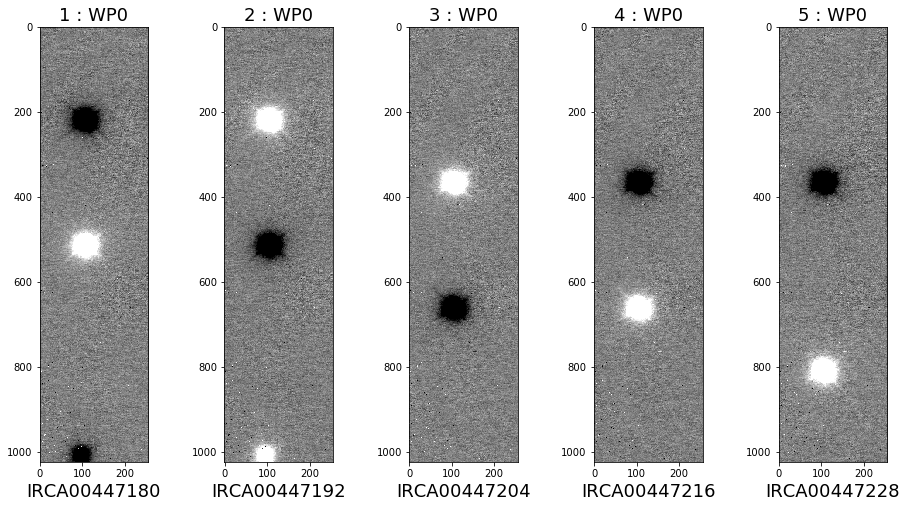

In [19]:
fontsize = 18

fig, ax = plt.subplots(nrows=1, ncols=ndither, figsize=(16,8))
for idx,i in enumerate(skysub_ch1[::wpangle*nframes][:ndither]):
    img = pf.getdata(i)
    hdr = pf.getheader(i)
    vmin, vmax = interval.get_limits(img)
    ax[idx].imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
    ax[idx].set_title(hdr['I_DTHPOS'], fontsize=fontsize)
    ax[idx].set_xlabel(hdr['FRAMEID'], fontsize=fontsize)

## Fix dead and hot pixels

In [20]:
from scipy.ndimage.filters import median_filter
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import medfilt
import numpy as np

def remove_badpix(img, kernel_size, threshold=None, replace_neg=False):
    #footprint = np.ones((3,3)); footprint[1,1]=0
    #filtered=median_filter(img, 3, footprint)
    if replace_neg==True:
        img[img<=0]=0
    filtered=medfilt(img,kernel_size) #or filtered=gaussian_filter(img,sigma=2)
    difference=np.abs(img-filtered)
    if threshold is None:
        threshold = 10*np.median(difference)
    #determine the hot pixels location given the threshold 
    hot_pixels = np.nonzero((np.abs(difference[1:-1,1:-1])>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column

    fixed_img = np.copy(img) 
    #replace hot pixels
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_img[y,x]=filtered[y,x]
    return fixed_img, filtered

img=pf.getdata(skysub_ch1[0])
fixed_img, filtered = remove_badpix(img, kernel_size=3)#,replace_neg=True);
difference= img - filtered

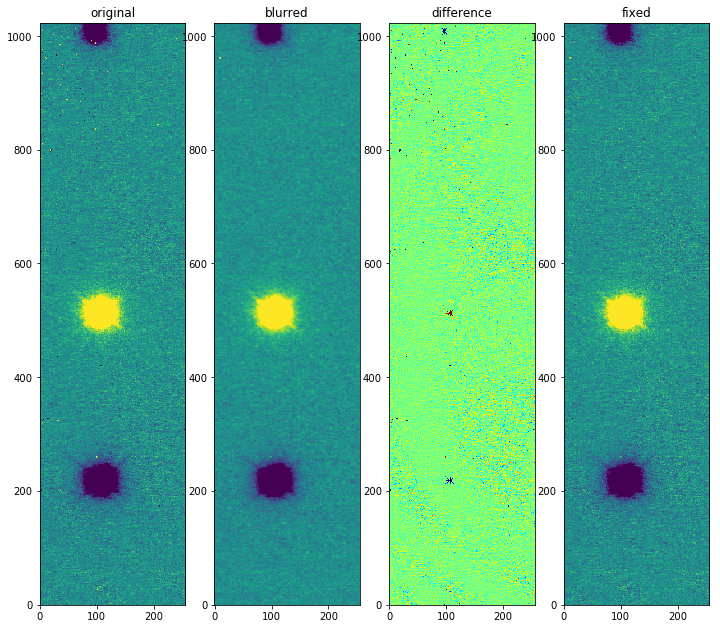

In [21]:
fig=plt.figure(figsize=(12,15))

vmin,vmax=interval.get_limits(fixed_img)
ax=plt.subplot(1,4,1)
ax.imshow(img,interpolation='nearest',origin='lower',vmin=vmin,vmax=vmax)
ax.set_title('original')
#
ax=plt.subplot(1,4,2)
ax.imshow(filtered,interpolation='nearest',origin='lower',vmin=vmin,vmax=vmax) #mask.
ax.set_title('blurred')
#
ax=plt.subplot(1,4,3)
ax3=ax.imshow(difference,interpolation='nearest',origin='lower',cmap='jet',vmin=vmin,vmax=vmax)
ax.set_title('difference')
#fig.colorbar(ax3,ax=ax)
ax=plt.subplot(1,4,4)
ax.imshow(fixed_img,interpolation='nearest',origin='lower',vmin=vmin,vmax=vmax)#,vmin=vmin,vmax=vmax,
ax.set_title('fixed')

## background estimation

In [22]:
def get_crop(image, centroid, box_size):
    '''
    simple cropping tool
    '''
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])
    return image_crop

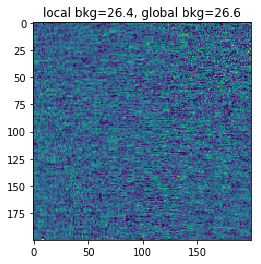

In [23]:
from astropy.stats import sigma_clipped_stats

bkg_img = get_crop(fixed_img, (110,700), 200)
vmin,vmax=interval.get_limits(bkg_img)
mean, median_global, stddev=sigma_clipped_stats(img[img>0], mask=None, mask_value=None, sigma=3.0)
mean, median_local, stddev=sigma_clipped_stats(bkg_img[bkg_img>0], mask=None, mask_value=None, sigma=3.0)
plt.title('local bkg={0:.1f}, global bkg={1:.1f}'.format(median_local, median_global))
plt.imshow(bkg_img-median_local,vmin=vmin, vmax=vmax)

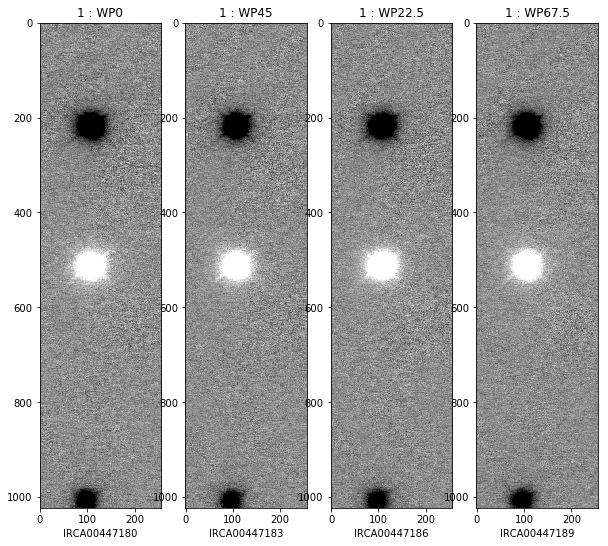

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.visualization import ZScaleInterval
interval= ZScaleInterval()

fig, ax = plt.subplots(nrows=1, ncols=wpangle, figsize=(10,20))
for idx,i in enumerate(skysub_ch1[::nframes][:wpangle]):
    img = pf.getdata(i)
    hdr = pf.getheader(i)
    #remove bad pix
    img, filtered = remove_badpix(img, kernel_size=5)#,replace_neg=True)
    #remove global bkg
    #bkg_img = get_crop(img, (110,800), 200)
    mean, median, stddev=sigma_clipped_stats(img[img>0], mask=None, mask_value=None, sigma=3.0)
    vmin, vmax = interval.get_limits(img-median)
    ax[idx].imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
    ax[idx].set_title(hdr['I_DTHPOS'])
    ax[idx].set_xlabel(hdr['FRAMEID'])

## combine I images (dither 1)

In [25]:
from scipy.ndimage.interpolation import shift

#I.keys()
#split I into each nframe: 12 I image each dict
I1_shifted = {}
I2_shifted = {}
I3_shifted = {}

kernel_size = 5

#nframe1
for m,i in enumerate(range(len(skysub_ch1))[::nframes]):
    hdr1 = pf.getheader(skysub_ch1[i])
    #print(hdr1['I_DTHPOS'])
    #ch1
    img1 = pf.getdata(skysub_ch1[i])
    #remove bkg
    mean, median, stddev=sigma_clipped_stats(img1[img1>0], sigma=3.0)
    img1-=median
    #remove bad pix
    img1, filtered = remove_badpix(img1, kernel_size)#,replace_neg=True)
    #shift
    img1_shifted = shift(img1, shift=(0,8.2), mode='wrap')
    #ch2
    img2 = pf.getdata(skysub_ch2[i])
    #remove bkg
    mean, median, stddev=sigma_clipped_stats(img2[img2>0], sigma=3.0)
    img2-=median
    #remove bad pix
    img2, filtered = remove_badpix(img2, kernel_size)#,replace_neg=True)
    I1_shifted[m] = (img1_shifted + img2)/2.

#nframe2
for n,i in enumerate(range(len(skysub_ch1))[::nframes]):
    hdr1 = pf.getheader(skysub_ch1[i+1])
    img1 = pf.getdata(skysub_ch1[i+1])
    #remove bkg
    mean, median, stddev=sigma_clipped_stats(img1[img1>0], sigma=3.0)
    img1-=median
    #remove bad pix
    img1, filtered = remove_badpix(img1, kernel_size)#,replace_neg=True)
    img1_shifted = shift(img1, shift=(0,8.2), mode='wrap')
    #ch2
    img2 = pf.getdata(skysub_ch2[i+1])
    #remove bkg
    mean, median, stddev=sigma_clipped_stats(img2[img2>0], sigma=3.0)
    img2-=median
    #remove bad pix
    img2, filtered = remove_badpix(img1, kernel_size)#,replace_neg=True)
    I2_shifted[n] = (img1_shifted + img2)/2.
    
#nframe3
for o,i in enumerate(range(len(skysub_ch1))[::nframes]):
    hdr1 = pf.getheader(skysub_ch1[i+2])
    img1 = pf.getdata(skysub_ch1[i+2])
    #remove bkg
    mean, median, stddev=sigma_clipped_stats(img1[img1>0], sigma=3.0)
    img1-=median
    img1_shifted = shift(img1, shift=(0,8.2), mode='wrap')
    #ch2
    img2 = pf.getdata(skysub_ch2[i+2])
    #remove bkg
    mean, median, stddev=sigma_clipped_stats(img2[img2>0], sigma=3.0)
    img2-=median
    #remove bad pix
    img2, filtered = remove_badpix(img2, kernel_size)#,replace_neg=True)
    I3_shifted[o] = (img1_shifted + img2)/2.

I1_shifted.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

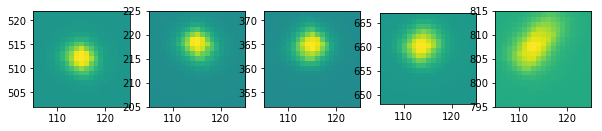

In [27]:
fig, ax = plt.subplots(1,5,figsize=(10,10))

#dither 1 to 5
xest = (105,125)
yest = [(502,522), (205,225), (352,372), (648,667), (795,815)]

#nframe 1
for i,j in enumerate(list(I1_shifted.keys())[::wpangle]): #only first set
    ax[i].imshow(I1_shifted[j])
    ax[i].set_xlim(xest)
    ax[i].set_ylim(yest[i])

(105, 125)

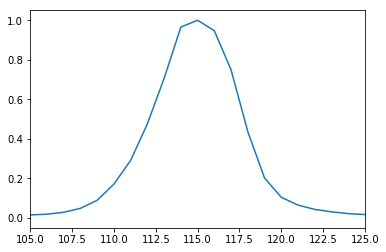

In [28]:
xslice=512
plt.plot(I1_shifted[0][xslice,:]/np.max(I1_shifted[0][xslice,:]))
plt.xlim(105,125)

In [29]:
fwhm_estimate=10
sigma=fwhm_estimate / (2*np.sqrt(2*np.log(2)))
sigma

4.2466090014400955

## centroid computation

In [30]:
convolve=True

from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from scipy.ndimage.filters import gaussian_filter

def get_centroid(img, num_stars=1, fwhm=10.0):
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)
    if convolve==True:
        #apply median filter to remove hot pixels
        img = gaussian_filter(img, sigma=sigma, mode='nearest')#,cval=0
    sources = daofind(img - median)
    #get index of brightest source
    idx = [i for i,j in enumerate(sources['peak']) if j == max(sources['peak'])]
    #get peak
    x_max, y_max = float(sources['xcentroid'][idx].data), float(sources['ycentroid'][idx].data)
    
    return (x_max, y_max)

In [32]:
from tqdm import tqdm

centroidsI1,centroidsI2,centroidsI3,centroidsI4 =[],[],[],[]

for key in tqdm(I1_shifted.keys()):
    centroidsI1.append(get_centroid(I1_shifted[key]))
for key in tqdm(I2_shifted.keys()):
    centroidsI2.append(get_centroid(I2_shifted[key]))
for key in tqdm(I3_shifted.keys()):
    centroidsI3.append(get_centroid(I3_shifted[key]))
    
centroidsI1

100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


[(114.89445846015602, 512.1812844149073),
 (114.77809044699515, 512.2159678292411),
 (114.71101834937933, 512.17231224902),
 (114.58406282568751, 512.2235061714678),
 (115.05772171508877, 217.91918861116855),
 (115.09612235421189, 217.9423222447548),
 (114.95549585749366, 218.09552950957945),
 (114.7013733685131, 218.1178851804172),
 (114.64310494666402, 364.670462323864),
 (114.38347581601208, 364.7008464521435),
 (114.36414032865959, 364.81823206710243),
 (114.11862097834543, 364.97209494928086),
 (113.76087148519618, 660.1581719655682),
 (113.64765870622348, 660.3010762654988),
 (113.73837803534298, 660.6297663495777),
 (113.28797242474403, 660.4569088390157),
 (113.48998327259699, 807.8970619807137),
 (113.57477008666741, 807.8784016050662),
 (113.273461814916, 807.8320576290739),
 (113.0854670224071, 807.9309964946348)]

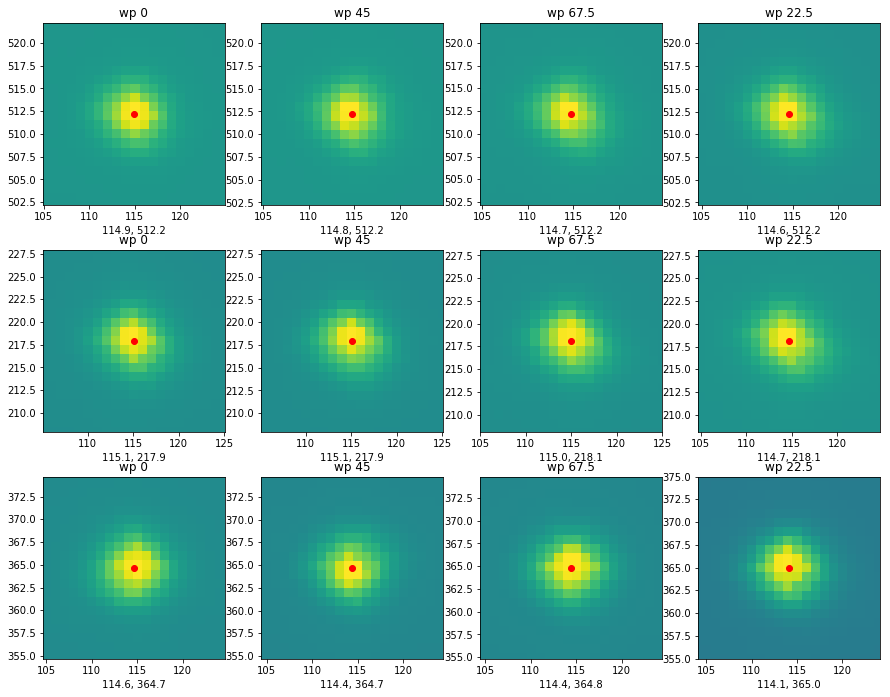

In [34]:
fig = plt.figure(figsize=(15,16))

dither_x = [row[0] for row in centroidsI1]
dither_y = [row[1] for row in centroidsI1]

n=10
#nframe 1
for i,j in enumerate(list(I1_shifted.keys())[:wpangle*nframes]):
    ax = plt.subplot(4,4,i+1)
    #vmin, vmax = interval.get_limits(I1[j])
    ax.imshow(I1_shifted[j])#,vmin=vmin,vmax=vmax)
    ax.set_xlim([dither_x[i]-n,dither_x[i]+n])
    ax.set_ylim([dither_y[i]-n,dither_y[i]+n])
    ax.plot(dither_x[i],dither_y[i],'ro', linewidth='10')
    ax.set_title('wp {}'.format([0,45,67.5,22.5][i%4]))
    ax.set_xlabel('{0:.1f}, {1:.1f}'.format(dither_x[i],dither_y[i]))
    #ax.axis('tight')

## shift and crop

In [35]:
#I was already shifted above before combining ch1 and ch2 into I,
#but I'll stick with I1_shifted after cropping image in all nframes

for key in I1_shifted.keys():
    #instead of shifting, crop at centroid
    I1_shifted[key] = get_crop(I1_shifted[key], centroidsI1[key], box_size=200)

for key in I2_shifted.keys():
    #instead of shifting, crop at centroid
    I2_shifted[key] = get_crop(I2_shifted[key], centroidsI2[key], box_size=200)

for key in I3_shifted.keys():
    #instead of shifting, crop at centroid
    I3_shifted[key] = get_crop(I3_shifted[key], centroidsI3[key], box_size=200)

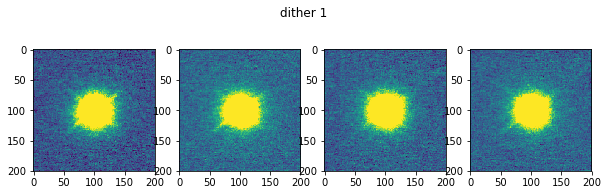

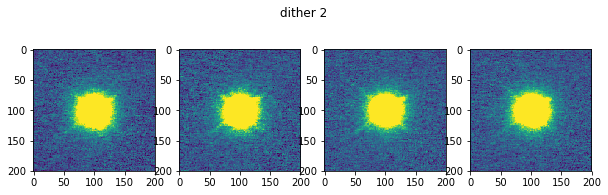

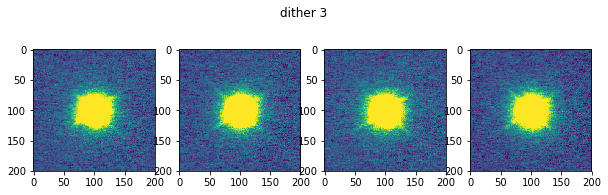

In [37]:
fig, ax = plt.subplots(1,4,figsize=(10,3))
#nframe 1
#dither 1
for i,key in enumerate(list(I1_shifted.keys())[:4]): #only first set
    vmin, vmax = interval.get_limits(I1_shifted[key])
    fig.suptitle('dither 1')
    ax[i].imshow(I1_shifted[key], vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1,4,figsize=(10,3))
#dither 2
for i,key in enumerate(list(I1_shifted.keys())[4:8]): #only first set
    fig.suptitle('dither 2')
    vmin, vmax = interval.get_limits(I1_shifted[key])
    ax[i].imshow(I1_shifted[key], vmin=vmin, vmax=vmax)
    
fig, ax = plt.subplots(1,4,figsize=(10,3))
#dither 3
for i,key in enumerate(list(I1_shifted.keys())[8:12]): #only first set
    vmin, vmax = interval.get_limits(I1_shifted[key])
    fig.suptitle('dither 3')
    ax[i].imshow(I1_shifted[key], vmin=vmin, vmax=vmax)

sum every first four image (=one WP cycle) in each I1, I2, I3 (i.e. nframe 1,2,3) to get Itot per dither.

## Combine aligned I image (I_shifted) per WP cycle: Itot

In [39]:
Itot1={} #nframe1 with 5 dithered images
Itot2={}
Itot3={}

#nframe 1: dither 1 to 5
for i,j in enumerate(list(I1_shifted.keys())[::4]):
    Itot1[i]=[]
    Itot1[i].append(I1_shifted[j])
    print(i,j)
    Itot1[i].append(I1_shifted[j+1])
    print(i,j+1)
    Itot1[i].append(I1_shifted[j+2])
    print(i,j+2)
    Itot1[i].append(I1_shifted[j+3])
    print(i,j+3)
    
#nframe 2: dither 1 to 5
for i,j in enumerate(list(I2_shifted.keys())[::4]): 
    Itot2[i]=[]
    Itot2[i].append(I2_shifted[j])
    Itot2[i].append(I2_shifted[j+1])
    Itot2[i].append(I2_shifted[j+2])
    Itot2[i].append(I2_shifted[j+3])
    
#nframe 3: dither 1 to 5
for i,j in enumerate(list(I3_shifted.keys())[::4]):
    Itot3[i]=[]
    Itot3[i].append(I3_shifted[j])
    Itot3[i].append(I3_shifted[j+1])
    Itot3[i].append(I3_shifted[j+2])
    Itot3[i].append(I3_shifted[j+3])

0 0
0 1
0 2
0 3
1 4
1 5
1 6
1 7
2 8
2 9
2 10
2 11
3 12
3 13
3 14
3 15
4 16
4 17
4 18
4 19


In [40]:
np.array(Itot1[0]).shape

(4, 200, 200)

In [41]:
for i in Itot1.keys():
    Itot1[i]=np.median(Itot1[i],axis=0)
    Itot2[i]=np.median(Itot2[i],axis=0)
    Itot3[i]=np.median(Itot3[i],axis=0)

after stacking,

In [42]:
np.array(Itot1[0]).shape

(200, 200)

In [43]:
Itot1.keys()

dict_keys([0, 1, 2, 3, 4])

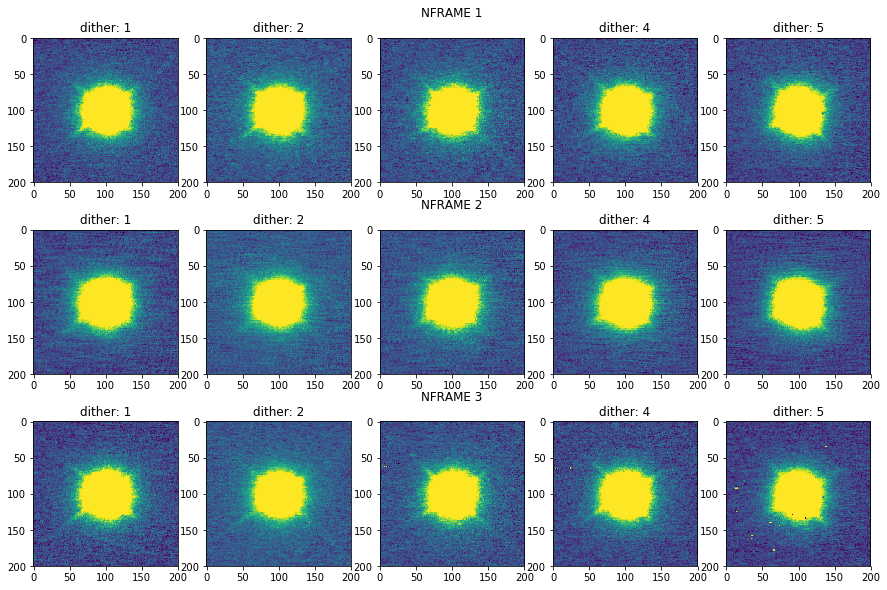

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for n,key in enumerate(Itot1.keys()):
    vmin1, vmax1 = interval.get_limits(Itot1[key])
    vmin2, vmax2 = interval.get_limits(Itot2[key])
    vmin3, vmax3 = interval.get_limits(Itot2[key])
    
    #Itot1: nframe1
    ax[0,n].imshow(Itot1[key], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Itot2: nframe2
    ax[1,n].imshow(Itot2[key], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Itot3 nframe3
    ax[2,n].imshow(Itot3[key], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

proper subplotting [here](https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot)

In [45]:
#sample for nframe3
for i in range(len(skysub_ch1))[::3]:
    hdr = pf.getheader(skysub_ch1[i+2])['I_DTHPOS']
    print(hdr)

1 : WP0
1 : WP45
1 : WP22.5
1 : WP67.5
2 : WP0
2 : WP45
2 : WP22.5
2 : WP67.5
3 : WP0
3 : WP45
3 : WP22.5
3 : WP67.5
4 : WP0
4 : WP45
4 : WP22.5
4 : WP67.5
5 : WP0
5 : WP45
5 : WP22.5
5 : WP67.5


As seen above, consecutive frames must be subtracted to get Q and U. The 20 I images per nframe will be split into 5 Q and 5 U images.

In [46]:
Q1 = {}
Q2 = {}
Q3 = {}
U1 = {}
U2 = {}
U3 = {}

#nframe 1
for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    Q1[h]=I1_shifted[i]-I1_shifted[i+1]
    #5 U images each nframe
    print(i+2,i+3)
    U1[h]=I1_shifted[i+2]-I1_shifted[i+3]
    
#nframe 2
for h,j in enumerate(range(len(I2_shifted))[::4]):
    Q2[h]=I2_shifted[j]-I2_shifted[j+1]
    U2[h]=I2_shifted[j+2]-I2_shifted[j+3]
    
#nframe 3
for h,k in enumerate(range(len(I3_shifted))[::4]):
    Q3[h]=I3_shifted[k]-I3_shifted[k+1]
    U3[h]=I3_shifted[k+2]-I3_shifted[k+3]
    

0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19


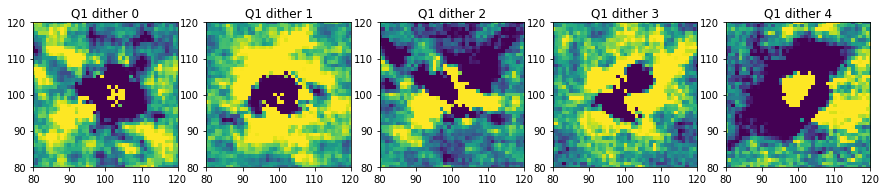

In [47]:
fig, ax = plt.subplots(1,5,figsize=(15,10))

#estimate of centroids for dither 1 to 5
# xest=  (90,120)
# yest = [(500,520), (210,230), (355,375), (655,675), (800,820)]

#nframe 1
n=100
m=20
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

shift o image (left) to the right by 8 pixels like what was done in realigning I images

## realigning Q and U using cross-correlation shifts

In [46]:
import image_registration as im_reg
im_reg??

In [ ]:
import image_registration as im_reg
from scipy.ndimage.interpolation import shift

Q1_shifted = {}
Q2_shifted = {}
Q3_shifted = {}
U1_shifted = {}
U2_shifted = {}
U3_shifted = {}

for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    wp0=I1_shifted[i]
    wp45=I1_shifted[i+1]
    dy, dx = im_reg.cross_correlation_shifts(wp0, wp45, maxoff=4, return_error=False, zeromean=True)
    print('dy={0:.2f}, dx={1:.2f}'.format(dy, dx))
    #aligned_ch3 = np.roll(np.roll(im3,int(yoff),1),int(xoff),0) #shift based on calculated centroid
    shifted = shift(wp45, shift=(dy, dx))
    Q1_shifted[h]=I1_shifted[i+1] - shifted

subpixel shifts does not minimize residual as shown on the bottom

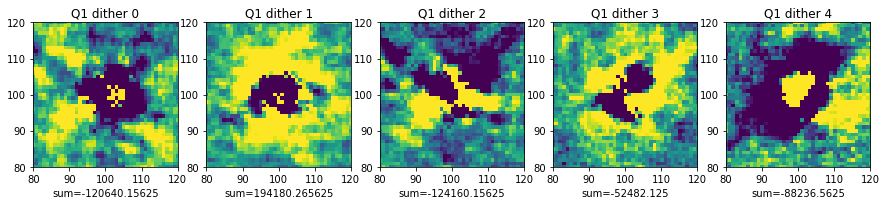

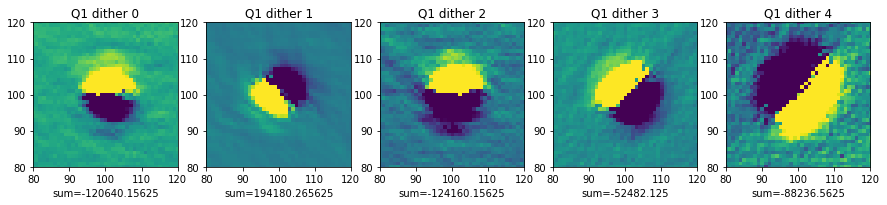

In [48]:
fig, ax = plt.subplots(1,5,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i+1))
    ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,5,figsize=(15,10))
for i,j in enumerate(Q1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i+1))
    ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

### random shifting to produce smallest residuals

In [49]:
from scipy.linalg import norm


ylims = xlims=[95,105]


def minimize_residual(img1, img2, show_fig=False):
    residuals = {}
    diff = {}
    dx=dy=np.arange(-1,2,0.5)
    if show_fig==True:
        fig, ax = plt.subplots(nrows=len(dx), ncols=len(dy), figsize=(20,20))
    for k,i in enumerate(dx):
        for l,j in enumerate(dy):
            img2_shifted = shift(img2, shift=(j, i), mode='wrap')
            diff[str(i)+','+str(j)] = img1 - img2_shifted
            #compute L2 norm
            residuals[str(i)+','+str(j)] = norm(diff[str(i)+','+str(j)], ord=2) #has same result as np.std()
            if show_fig==True:
                ax[k,l].imshow(diff[str(i)+','+str(j)])
                ax[k,l].set_xlim(xlims)
                ax[k,l].set_ylim(ylims)
                ax[k,l].set_axis_off()
                ax[k,l].set_title('dx={0:.1f},dy={1:.1f}'.format(i,j))
                
            
    #get smallest flux
    min_flux = np.min([residuals[k] for k in residuals.keys()])
    #get indices of shifts with minimum flux (dy,dx)
    idx = [k for k in residuals.keys() if residuals[k] == min_flux]
    #get image with smallest residual
    img = diff[idx[0]]
    return (img, idx[0]) #dict of images

test

In [50]:
#wp0 and wp45
img1=I1_shifted[0]
img2=I1_shifted[1]

(img, shift_xy) = minimize_residual(img1, img2)

In [51]:
Q1_shifted = {}
Q2_shifted = {}
Q3_shifted = {}
U1_shifted = {}
U2_shifted = {}
U3_shifted = {}

#nframe1
for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    wp0=I1_shifted[i]
    wp45=I1_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual(wp0, wp45)
    print('dx,dy={}'.format(Qshift_xy))
    Q1_shifted[h]= Qimg
    #shift to make U
    print(i+2,i+3)
    wp225=I1_shifted[i+2]
    wp675=I1_shifted[i+3]
    '''
    #U must be shifted independently from Q
    dx, dy = shift_xy[0], shift_xy[1]
    wp675_shifted = shift(wp675, shift=(int(dy), int(dx)))
    U1_shifted[h]= wp225 - wp675_shifted '''
    (Uimg, Ushift_xy) = minimize_residual(wp225, wp675)
    print('dx,dy={}'.format(Ushift_xy))
    U1_shifted[h]= Uimg

#nframe2
for h,i in tqdm(enumerate(range(len(I2_shifted))[::4])):
    #print(i,i+1)
    wp0=I2_shifted[i]
    wp45=I2_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual(wp0, wp45)
    #print('dx,dy={}'.format(Qshift_xy))
    Q2_shifted[h]= Qimg
    #shift to make U
    #print(i+2,i+3)
    wp225=I2_shifted[i+2]
    wp675=I2_shifted[i+3]
    (Uimg, Ushift_xy) = minimize_residual(wp225, wp675)
    #print('dx,dy={}'.format(Ushift_xy))
    U2_shifted[h]= Uimg
    
#nframe3
for h,i in tqdm(enumerate(range(len(I3_shifted))[::4])):
    #print(i,i+1)
    wp0=I3_shifted[i]
    wp45=I3_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual(wp0, wp45)
    #print('dx,dy={}'.format(Qshift_xy))
    Q3_shifted[h]= Qimg
    #shift to make U
    #print(i+2,i+3)
    wp225=I3_shifted[i+2]
    wp675=I3_shifted[i+3]
    (Uimg, Ushift_xy) = minimize_residual(wp225, wp675)
    #print('dx,dy={}'.format(Ushift_xy))
    U3_shifted[h]= Uimg
    
print('---DONE---')

(0, 1)
dx,dy=0.5,0.0
(2, 3)
dx,dy=0.0,0.0
(4, 5)
dx,dy=0.0,0.0
(6, 7)
dx,dy=0.5,0.0
(8, 9)
dx,dy=0.5,0.0
(10, 11)
dx,dy=0.5,0.0
(12, 13)
dx,dy=0.0,0.0
(14, 15)
dx,dy=0.5,0.0
(16, 17)
dx,dy=0.0,0.5
(18, 19)


0it [00:00, ?it/s]

dx,dy=0.5,0.0


5it [00:03,  1.54it/s]
5it [00:03,  1.38it/s]

---DONE---


shifted Q comparison

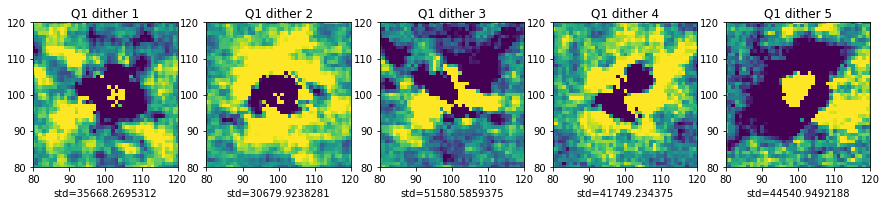

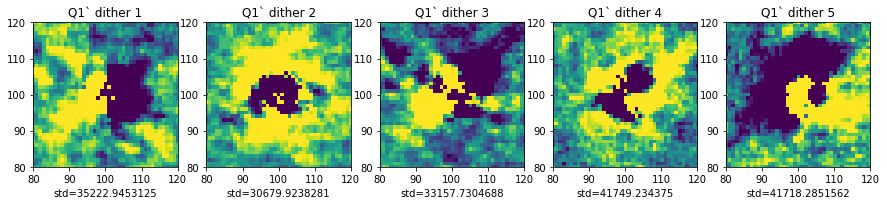

In [52]:
fig, ax = plt.subplots(1,5,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i+1))
    #ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlabel('std={}'.format(np.linalg.norm(Q1[j],ord=2)))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,5,figsize=(15,10))
for i,j in enumerate(Q1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1` dither {}'.format(i+1))
    ax[i].set_xlabel('std={}'.format(np.linalg.norm(Q1_shifted[j],ord=2)))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

shifted U comparison

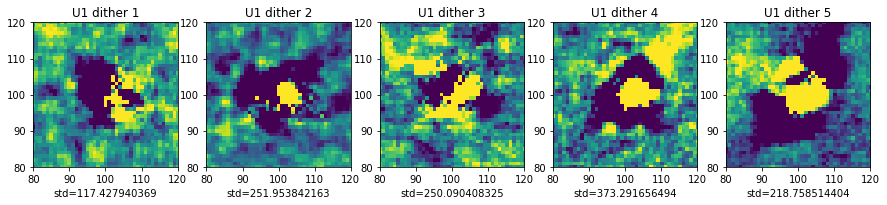

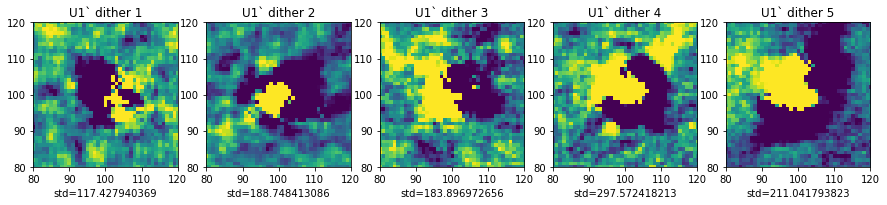

In [53]:
fig, ax = plt.subplots(1,5,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(U1.keys()): #only first set
    vmin, vmax = interval.get_limits(U1[j])
    ax[i].imshow(U1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('U1 dither {}'.format(i+1))
    #ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlabel('std={}'.format(np.std(U1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,5,figsize=(15,10))
for i,j in enumerate(U1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(U1[j])
    ax[i].imshow(U1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('U1` dither {}'.format(i+1))
    ax[i].set_xlabel('std={}'.format(np.std(U1_shifted[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

In [54]:
len(Q1_shifted)

5

In [55]:
len(U1_shifted)

5

In [56]:
Q1_shifted.keys()

[0, 1, 2, 3, 4]

In [57]:
Q2_shifted.keys()

[0, 1, 2, 3, 4]

In [58]:
PI1={}
PI2={}
PI3={}

for i,q in enumerate(Q1.keys()):
    #5 PI image each nframe
    PI1[i]=np.sqrt(Q1_shifted[q]**2+U1_shifted[q]**2)
    PI2[i]=np.sqrt(Q2_shifted[q]**2+U2_shifted[q]**2)
    PI3[i]=np.sqrt(Q3_shifted[q]**2+U3_shifted[q]**2)

In [59]:
len(PI1)

5

## Q

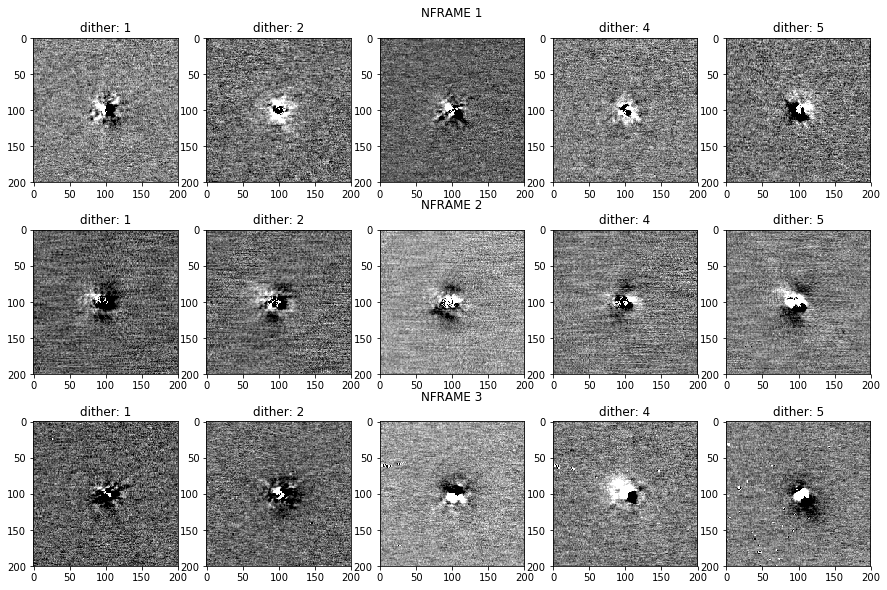

In [60]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for n,key in enumerate(Q1_shifted.keys()):
    vmin1, vmax1 = interval.get_limits(Q1_shifted[key])
    vmin2, vmax2 = interval.get_limits(Q2_shifted[key])
    vmin3, vmax3 = interval.get_limits(Q2_shifted[key])
    
    #Q1: nframe1
    ax[0,n].imshow(Q1_shifted[key], vmin=vmin1, vmax=vmax1, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Q2: nframe2
    ax[1,n].imshow(Q2_shifted[key], vmin=vmin2, vmax=vmax2, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Q3 nframe3
    ax[2,n].imshow(Q3_shifted[key], vmin=vmin3, vmax=vmax3, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## U

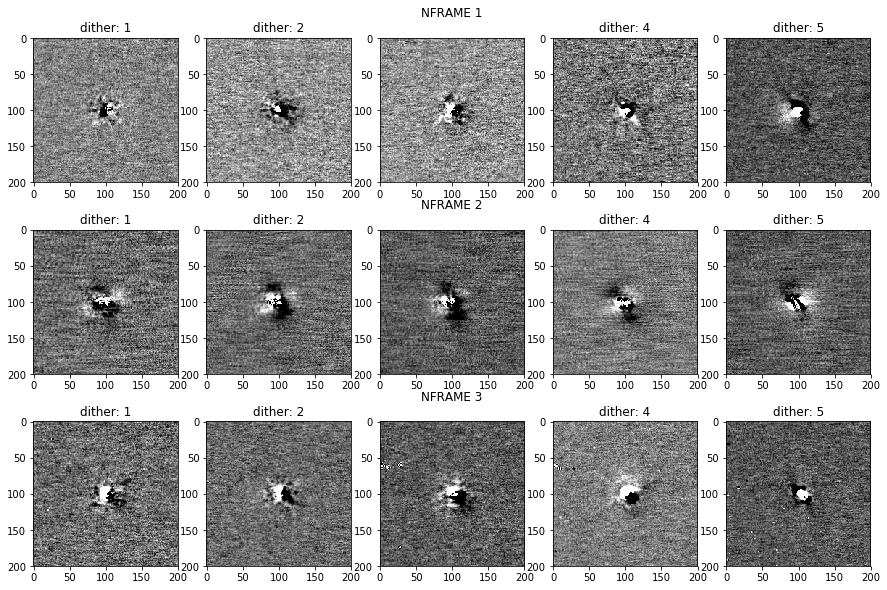

In [61]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for n,key in enumerate(U1_shifted.keys()):
    vmin1, vmax1 = interval.get_limits(U1_shifted[key])
    vmin2, vmax2 = interval.get_limits(U2_shifted[key])
    vmin3, vmax3 = interval.get_limits(U2_shifted[key])
    
    #Q1: nframe1
    ax[0,n].imshow(U1_shifted[key], vmin=vmin1, vmax=vmax1, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Q2: nframe2
    ax[1,n].imshow(U2_shifted[key], vmin=vmin2, vmax=vmax2, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Q3 nframe3
    ax[2,n].imshow(U3_shifted[key], vmin=vmin3, vmax=vmax3, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## PI

In [62]:
PI3.keys()

[0, 1, 2, 3, 4]

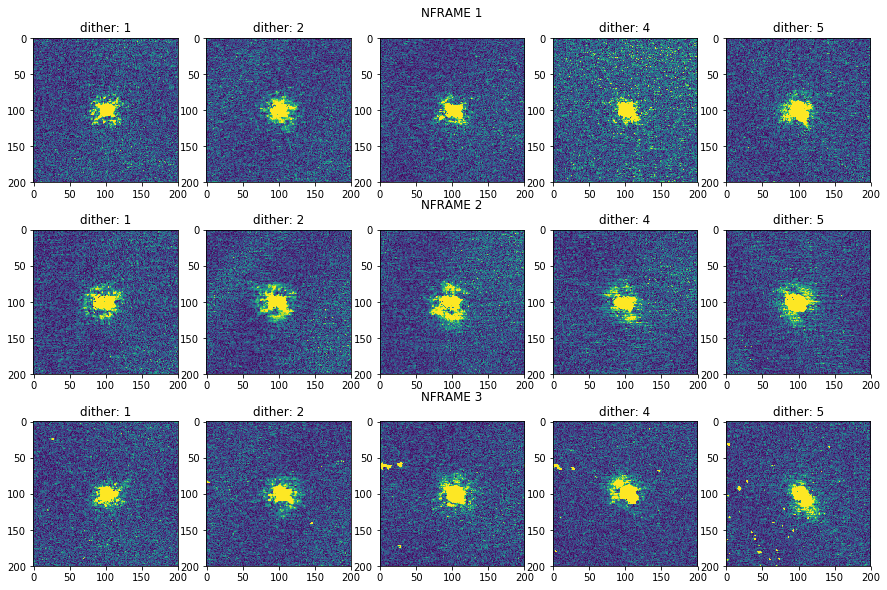

In [63]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for i in range(5):
    vmin1, vmax1 = interval.get_limits(PI1[i])
    vmin2, vmax2 = interval.get_limits(PI2[i])
    vmin3, vmax3 = interval.get_limits(PI3[i])
    
    ax[0,i].imshow(PI1[i], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,i].set_title('dither: {}'.format(i+1))
    ax[1,i].imshow(PI2[i], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,i].set_title('dither: {}'.format(i+1))
    ax[2,i].imshow(PI3[i], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,i].set_title('dither: {}'.format(i+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## median combined I, Q, U, PI (per dither)

In [64]:
Itot_med = {}
for n,key in enumerate(Itot1.keys()):
    Itot_med[n] = []
    #dither 1
    Itot_med[n].append(Itot1[key])
    Itot_med[n].append(Itot2[key])
    Itot_med[n].append(Itot3[key])
    #stack
    Itot_med[n]=np.median(Itot_med[n],axis=0)

Q_med = {}
for n,key in enumerate(Q1_shifted.keys()):
    Q_med[n] = []
    #dither 1
    Q_med[n].append(Q1_shifted[key])
    Q_med[n].append(Q2_shifted[key])
    Q_med[n].append(Q3_shifted[key])
    #stack
    Q_med[n]=np.median(Q_med[n],axis=0)
    
U_med = {}
for n,key in enumerate(U1_shifted.keys()):
    U_med[n] = []
    #dither 1
    U_med[n].append(U1_shifted[key])
    U_med[n].append(U2_shifted[key])
    U_med[n].append(U3_shifted[key])
    #stack
    U_med[n]=np.median(U_med[n],axis=0)
    
PI_med = {}
for n,key in enumerate(PI1.keys()):
    PI_med[n] = []
    #dither 1
    PI_med[n].append(PI1[key])
    PI_med[n].append(PI2[key])
    PI_med[n].append(PI3[key])
    #stack
    PI_med[n]=np.median(PI_med[n],axis=0)

## Stacked I, Q,U, & PI per dither

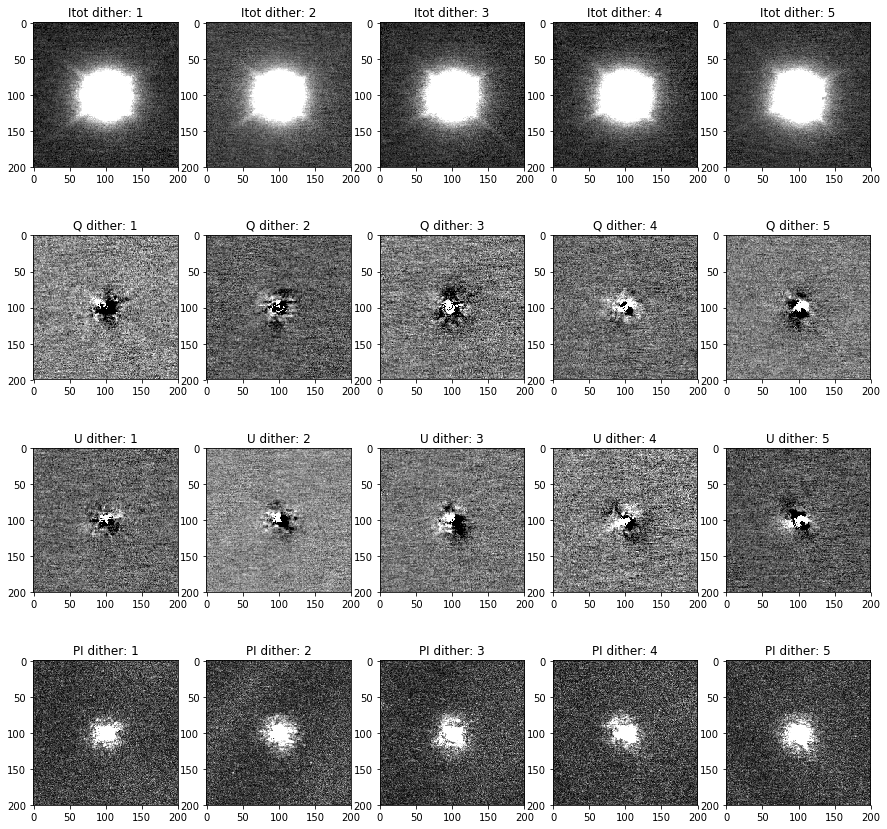

In [65]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

for i in range(5):
    vmin0, vmax0 = interval.get_limits(Itot_med[i])
    vmin1, vmax1 = interval.get_limits(Q_med[i])
    vmin2, vmax2 = interval.get_limits(U_med[i])
    vmin3, vmax3 = interval.get_limits(PI_med[i])
    
    ax[0,i].imshow(Itot_med[i], vmin=vmin0, vmax=vmax0, cmap='gray')
    ax[0,i].set_title('Itot dither: {}'.format(i+1))
    ax[1,i].imshow(Q_med[i], vmin=vmin1, vmax=vmax1, cmap='gray')
    ax[1,i].set_title('Q dither: {}'.format(i+1))
    ax[2,i].imshow(U_med[i], vmin=vmin2, vmax=vmax2, cmap='gray')
    ax[2,i].set_title('U dither: {}'.format(i+1))
    ax[3,i].imshow(PI_med[i], vmin=vmin3, vmax=vmax3, cmap='gray')
    ax[3,i].set_title('PI dither: {}'.format(i+1))

## Combine dithered Itot, Q, U, PI

In [66]:
Itot_med_final = []
Q_med_final = []
U_med_final = []
PI_med_final = []

for i in range(5):
    #combine per dither
    Itot_med_final.append(Itot_med[i])
    Q_med_final.append(Q_med[i])
    U_med_final.append(U_med[i])
    PI_med_final.append(PI_med[i])

Itot_med_final = np.median(Itot_med_final, axis=0)
Q_med_final = np.median(Q_med_final, axis=0)
U_med_final = np.median(U_med_final, axis=0)
PI_med_final = np.median(PI_med_final, axis=0)

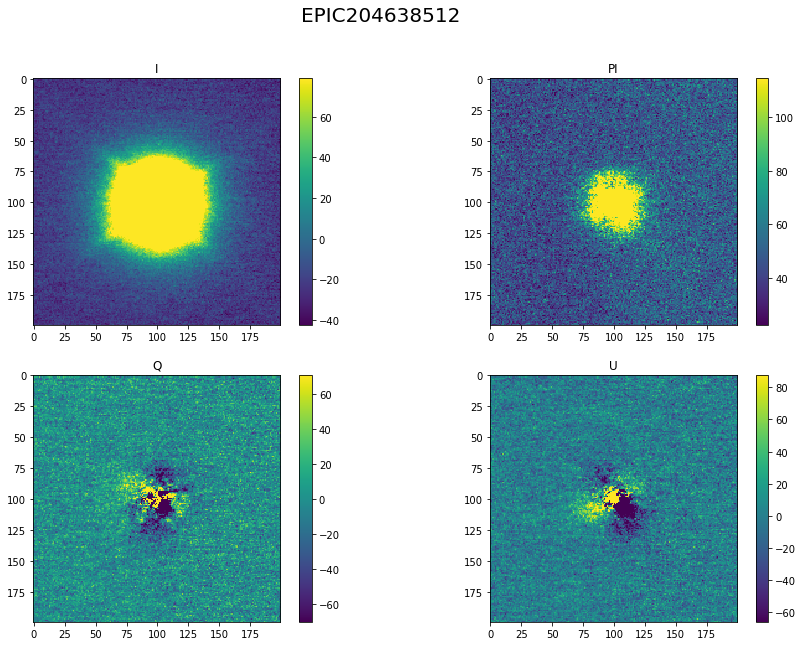

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

vmin0, vmax0 = interval.get_limits(Itot_med_final)
vmin1, vmax1 = interval.get_limits(PI_med_final)
#vmin1, vmax1 = interval.get_limits(PI_crop/I_crop)
vmin2, vmax2 = interval.get_limits(Q_med_final)
vmin3, vmax3 = interval.get_limits(U_med_final)

ax1 = ax[0,0].imshow(Itot_med_final, vmin=vmin0, vmax=vmax0)
ax[0,0].set_title('I')
fig.colorbar(ax1, ax=ax[0,0])#, orientation='horizontal')
#ax2 = ax[0,1].imshow(PI_crop/I_crop, vmin=vmin1, vmax=vmax1)
ax2 = ax[0,1].imshow(PI_med_final, vmin=vmin1, vmax=vmax1)
fig.colorbar(ax2, ax=ax[0,1])
#ax[0,1].set_title('PI/I')
ax[0,1].set_title('PI')
ax3 = ax[1,0].imshow(Q_med_final, vmin=vmin2, vmax=vmax2)
fig.colorbar(ax3, ax=ax[1,0])
ax[1,0].set_title('Q')
ax4 = ax[1,1].imshow(U_med_final, vmin=vmin3, vmax=vmax3)
fig.colorbar(ax4, ax=ax[1,1])
ax[1,1].set_title('U')
plt.suptitle(pf.getheader(skysub_ch1[0])['OBJECT'], fontsize=20)
#plt.tight_layout()
# ax[0,0].imshow(np.log(I_crop))
# ax[0,1].imshow(np.log(PI_crop))
# ax[1,0].imshow(np.log(Q_crop))
# ax[1,1].imshow(np.log(U_crop))

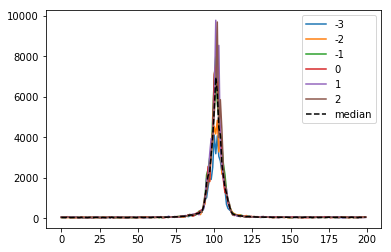

In [68]:
xslices=[]
for i in np.arange(-3,3,1):
    xslice=PI_med_final[PI_med_final.shape[1]/2+i,:]
    plt.plot(xslice, label=i)
    xslices.append(xslice)

xslice=np.median(xslices,axis=0)
plt.plot(xslice, 'k--', label='median')
plt.legend()

## estimating FWHM

A: 111.052460877
mu: 101.264582724
sigma= 3.36240590139
eps: 1.40948272669
est_fwhm= 7.91846589778


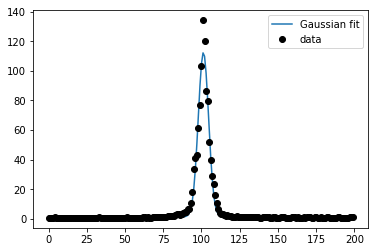

In [69]:
#using scipy
from scipy.optimize import curve_fit

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

#normalized
ydata = xslice/np.median(xslice)
xdata = np.array(range(len(ydata)))
xmean = len(xdata)/2
sigma = np.std(ydata)
#fitting
eps =0
popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [1, xmean, sigma, eps])

plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
plt.plot(xdata,ydata,'ok', label='data')
plt.legend()

est_fwhm=2.355*np.abs(popt[2])
print('A: {}\nmu: {}\nsigma= {}\neps: {}\nest_fwhm= {}'.format(popt[0],popt[1], popt[2], popt[3], est_fwhm))


## Polarization vectors

In [70]:
'''
pol vector class
'''

from scipy.ndimage.filters import gaussian_filter
from numpy import *
import matplotlib.pyplot as pl

max_length=10       # Pol=100 % in pixel

### Classes and Modules ###
class Linear_pol_vector:
    def __init__(self,x,y,I,Q,U,ax,max_length=10,linewidth=2,color='b'):
        self.x=x
        self.y=y
        self.I=I
        self.Q=Q
        self.U=U
        self.ax=ax
        self.max_length=max_length
        self.P=sqrt(Q**2+U**2)/I
        if self.P == 0:
            self.pl,=ax.plot([self.x,self.x],[self.y,self.y],linestyle='-',color=color,
                       linewidth=2)
        else:
            self.ang=arctan2(self.U,self.Q)*0.5
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl,=ax.plot([self.x-dx,self.x+dx],[self.y-dy,self.y+dy], linestyle='-',color=color,linewidth=2)
    def change_max_length(self,max_length=10):
        if self.P != 0:
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl.set_xdata=[self.x-dx,self.x+dx]
            self.pl.set_ydata=[self.y-dy,self.y+dy]
    def reset(self):
        self.change_max_length()
        self.pl.set_linewidth=2
        self.pl.set_color='w'

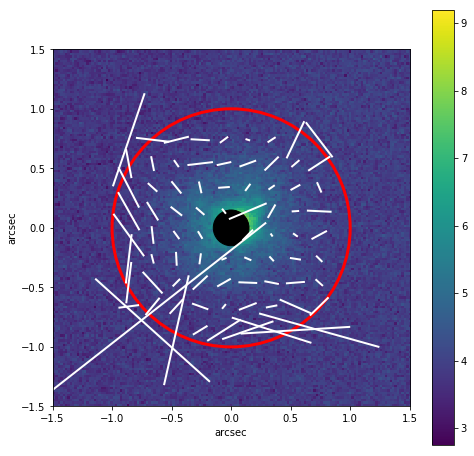

In [80]:
from photutils import CircularAperture
from matplotlib.patches import Ellipse
############################################
'''
pol vector plot
'''

scale= 0.020 #ircs_pix_size: mas/pix
box_size = 200

#xcenter = int(sources['xcentroid'][2])
#ycenter = int(sources['ycentroid'][2])
xcenter = ycenter = box_size/2.0

#convert to AU by multiplying arsec with parsec
#x_in_AU=(np.arange(box_size)-xcenter)*scale*distance
#y_in_AU=(np.arange(box_size)-ycenter)*scale*distance

x_in_as=(np.arange(box_size)-xcenter)*scale
y_in_as=(np.arange(box_size)-ycenter)*scale

img_PI = PI_med_final
img_Q = Q_med_final
img_U = U_med_final
img_I = Itot_med_final

#shift reference w.r.t. the target coordinate
fig, ax = plt.subplots(1,1, figsize=(8,8))
a = 0-xcenter
b = box_size - xcenter
c = 0 -ycenter
d =  box_size - ycenter
extent_PI=np.array([a,b,c,d])*scale


#------------------PLOT image---------------------#
#normalize with I?
data = img_PI#/img_I
#vmin,vmax= interval.get_limits(data)
ax1=ax.imshow(np.log(data),extent=extent_PI,interpolation='nearest',origin='lower')#, cmap='gray', vmin=vmin,vmax=vmax)

#aperture
aperture=CircularAperture((0,0), r=1) #arcsec
aperture.plot(color='r', linewidth=3, ax=ax)
fig.colorbar(ax1,ax=ax)

#------------------PLOT vectors---------------------#
#average of pol signal 
#varray=[]
dx=dy=1
area=(2*dx+1)*(2*dy+1)

#extent of the region where pol vectors will be drawn
dn = 0.85/scale #1arcsec/scale=50 pix
xmin=xcenter-dn 
xmax=xcenter+dn
ymin=ycenter-dn
ymax=ycenter+dn
#pix; spacing between vectors
inc=10 
for x in np.arange(xmin,xmax,inc):
    for y in np.arange(ymin,ymax,inc):
        x,y=int(x), int(y)
        r_in_as=sqrt(x_in_as[x]**2+y_in_as[y]**2)
        if r_in_as < 0.1: continue #put pol vectors outside r=15
        if np.log(data[y,x]) < 9.0: #threshold of polarization (smaller is wider)
            I=sum(img_I[y-dy:y+dy+1,x-dx:x+dx+1])/area
            Q=sum(img_Q[y-dy:y+dy+1,x-dx:x+dx+1])/area
            U=sum(img_U[y-dy:y+dy+1,x-dx:x+dx+1])/area
            v=Linear_pol_vector(x_in_as[x],y_in_as[y],I,-Q,-U,ax,max_length=1,color='w')
#savefig('obj_PI_conva_sigma05_pol.fits',v???)
plt.draw()
#arcsec
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.xlabel('arcsec')
plt.ylabel('arcsec')

#Takami+13 used 0."3 arcsec in diameter mask
#0."3 arcsec/*0.00948arcsec/pix = 31.65 pixels
hmask,wmask= 0.3,0.3 # 0.3/scale,0.3/scale #radius = 15 pix = 20 AU
m=Ellipse(xy=(0,0),height=hmask,width=wmask)
ax.add_artist(m)
m.set_color('k')

plt.show()

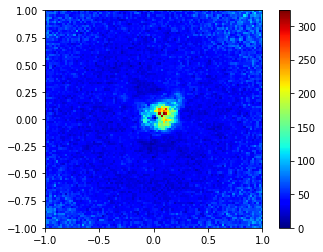

In [79]:
power_index=1.2
PI_rescaled=np.copy(img_PI)#/img_I)
for x in range(PI_rescaled.shape[1]):
    for y in range(PI_rescaled.shape[0]):
        r=sqrt((x-xcenter)**2+(y-ycenter)**2)*scale
        PI_rescaled[y,x]*=r**power_index

vmin,vmax=interval.get_limits(PI_rescaled)
plt.imshow(PI_rescaled,extent=extent_PI,interpolation='nearest',origin='lower', cmap='jet')#,vmin=0,vmax=20)
plt.axis([-1,1,-1,1])
plt.colorbar()